In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle

import matplotlib.pyplot as plt
import cv2

# Carregando os modelos trabalhados anteriormente (salvos)

In [2]:
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
model_svm =  pickle.load(open('./model/model_svm.pickle',mode='rb')) 
pca_models = pickle.load(open('./model/pca_dict.pickle',mode='rb')) 

In [3]:
model_pca = pca_models['pca'] 
mean_face_arr = pca_models['mean_face'] 

# Criando o Pipeline

In [5]:
img = cv2.imread('./test_images/getty_test.jpg')

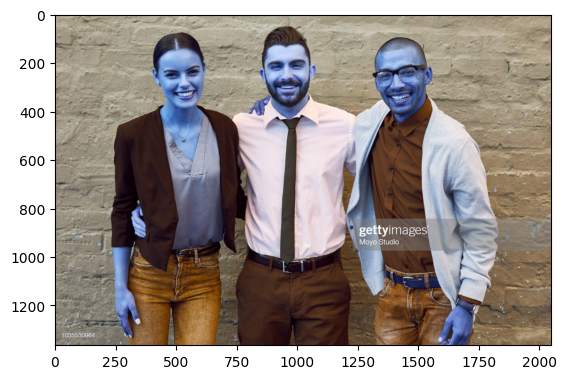

In [6]:
plt.imshow(img)

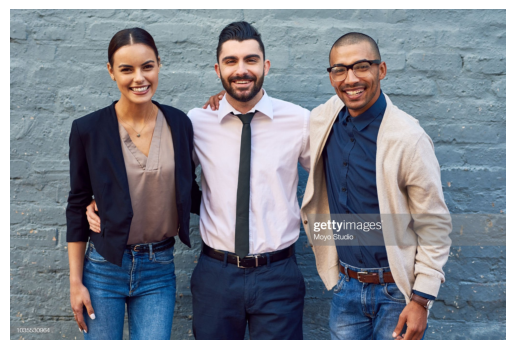

In [7]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [8]:
# Lendo a imagem
img = cv2.imread('./test_images/getty_test.jpg') # BGR

# Convertendo para a escala cinza
gray =  cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

# Crop Face usando cascade classifier
faces = haar.detectMultiScale(gray,1.5,3)
predictions = []
for x,y,w,h in faces:
    roi = gray[y:y+h,x:x+w]
    
    # Normalização (0-1)
    roi = roi / 255.0
    
    # Redimensionamento (100,100)
    if roi.shape[1] > 100:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
        
    # Flattening (1x10000)
    roi_reshape = roi_resize.reshape(1,10000)
    
    # Subtração com a média
    roi_mean = roi_reshape - mean_face_arr 
    
    # Eigen Image
    eigen_image = model_pca.transform(roi_mean)
    eig_img = model_pca.inverse_transform(eigen_image)
    
    # Previsões com o modelo SVM
    results = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max()
    
    # Report
    text = "%s : %d"%(results[0],prob_score_max*100)
    
    if results[0] == 'male':
        color = (255,255,0)
    else:
        color = (255,0,255)
        
    cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color,-1)
    cv2.putText(img,text,(x,y),cv2.FONT_HERSHEY_PLAIN,3,(255,255,255),5)
    output = {
        'roi':roi,
        'eig_img': eig_img,
        'prediction_name':results[0],
        'score':prob_score_max
    }
    
    predictions.append(output)

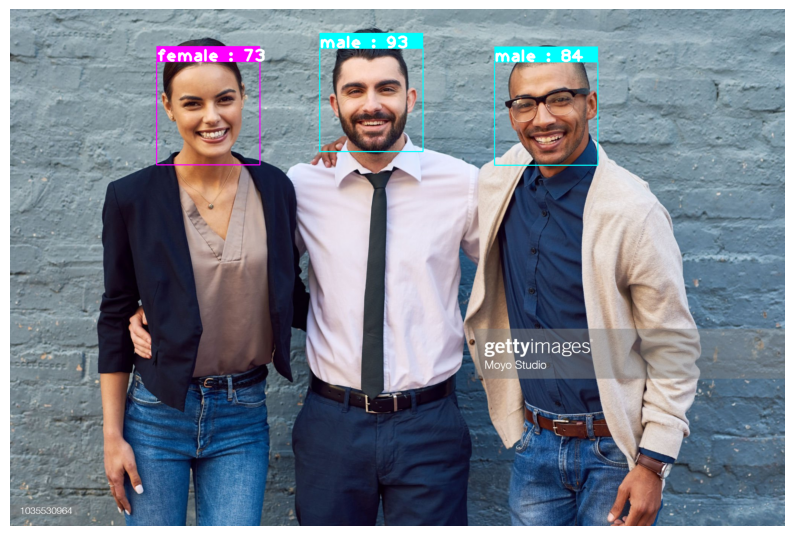

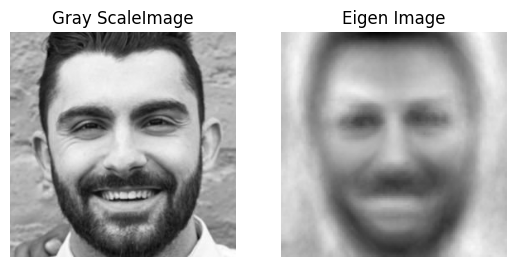

Predicted Gender = male
Predicted score = 93.66 %
----------------------------------------------------------------------------------------------------


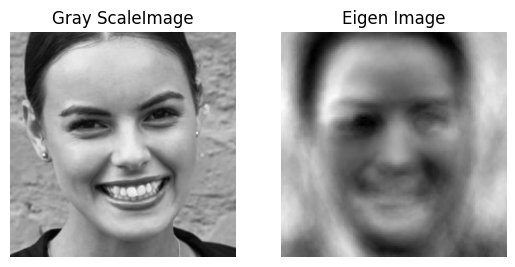

Predicted Gender = female
Predicted score = 73.68 %
----------------------------------------------------------------------------------------------------


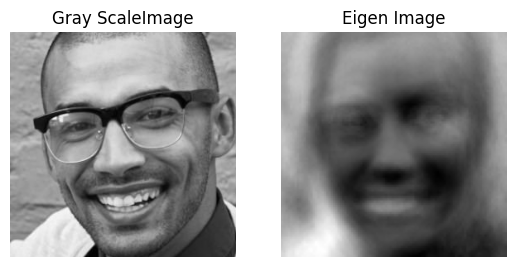

Predicted Gender = male
Predicted score = 84.18 %
----------------------------------------------------------------------------------------------------


In [9]:
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

## generate report
for i in range(len(predictions)):
    obj_gray = predictions[i]['roi'] #gray scale
    obj_eig = predictions[i]['eig_img'].reshape(100,100) #eigen image
    plt.subplot(1,2,1)
    plt.imshow(obj_gray,cmap='gray')
    plt.title('Gray ScaleImage')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(obj_eig,cmap='gray')
    plt.title('Eigen Image')
    plt.axis('off')
    
    plt.show()
    print('Predicted Gender =',predictions[i]['prediction_name'])
    print('Predicted score = {:,.2f} %'.format(predictions[i]['score']*100))
    
    print('-'*100)